# Named Entity Recognition with Bi-LSTM on CoNLL-2003 dataset

# 1. Data Loading

In [2]:
%pip install seqeval

# Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import numpy as np
from sklearn.metrics import classification_report
from seqeval.metrics import f1_score, classification_report as seq_classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import pandas as pd
import os
from itertools import product

In [3]:
# Load the CoNLL-2003 dataset
dataset = load_dataset("eriktks/conll2003", trust_remote_code=True)
print(dataset)

README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


In [4]:
# View the first training example
print(dataset['train'][0])

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


# 2. Vocabulary Building

In [5]:
# Build vocabulary based on frequency of words
counter = Counter()
for tokens in dataset['train']['tokens']:
    counter.update(tokens)

# Select the most common 30000 words **
vocab = ['<PAD>', '<UNK>'] + [word for word, freq in counter.most_common(30000)]

# Build word mappings
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

In [6]:
print('Vocabulary size:', len(vocab))
print('Most common 10 words:', vocab[:10])

print('First 5 words:', list(word2idx.items())[:5])
print('First 5 indices:', list(idx2word.items())[:5])

Vocabulary size: 23625
Most common 10 words: ['<PAD>', '<UNK>', '.', ',', 'the', 'of', 'in', 'to', 'a', '(']
First 5 words: [('<PAD>', 0), ('<UNK>', 1), ('.', 2), (',', 3), ('the', 4)]
First 5 indices: [(0, '<PAD>'), (1, '<UNK>'), (2, '.'), (3, ','), (4, 'the')]


In [7]:
# Build tag mappings
ner_tags = dataset['train'].features['ner_tags'].feature.names  

tag2idx = {tag: idx for idx, tag in enumerate(ner_tags)}    #{'O': 0, 'B-PER': 1,..., 'I-MISC': 8}
# Add padding tag
tag2idx['<PAD>'] = len(tag2idx)         #{'O': 0, 'B-PER': 1,..., 'I-MISC': 8, '<PAD>': 9}

idx2tag = {idx: tag for tag, idx in tag2idx.items()}

In [8]:
print('NER tags:', ner_tags)
print('Tag to index:', tag2idx)
print('Index to tag:', idx2tag)

NER tags: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
Tag to index: {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8, '<PAD>': 9}
Index to tag: {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC', 9: '<PAD>'}


In [9]:
# Calculate the length of each sentence
sentence_lengths = [len(tokens) for tokens in dataset['train']['tokens']]

# Calculate the maximum length on 99.9%
MAX_LEN = int(np.percentile(sentence_lengths, 99.9))

print(f"Suggested max_len based on 99.9 percentile: {MAX_LEN}")

Suggested max_len based on 99.9 percentile: 55


# 3. Model Definition

In [10]:
# Define a custom Dataset class for NER
class NERDataset(Dataset):
    def __init__(self, tokens_list, tags_list, word2idx, tag2idx, max_len=128): 
        self.tokens_list = tokens_list
        self.tags_list = tags_list
        self.word2idx = word2idx
        self.tag2idx = tag2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.tokens_list)

    def __getitem__(self, idx):
        tokens = self.tokens_list[idx]
        tags = self.tags_list[idx]

        # Convert tokens to indices
        token_ids = [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]
        # Convert tags to indices
        tag_ids = [tag for tag in tags] 

        # Truncate if longer than max_len
        if len(token_ids) > self.max_len:
            token_ids = token_ids[:self.max_len]
            tag_ids = tag_ids[:self.max_len]

        # Record original length to use in evaluation **
        length = len(token_ids)

        # Padding
        padding_length = self.max_len - length
        token_ids += [self.word2idx['<PAD>']] * padding_length
        tag_ids += [self.tag2idx['<PAD>']] * padding_length  # Pad tags with '<PAD>'


        return {
            'tokens': torch.tensor(token_ids, dtype=torch.long),
            'tags': torch.tensor(tag_ids, dtype=torch.long),
            'length': torch.tensor(length, dtype=torch.long)
        }

In [11]:
# Define BiLSTM model
class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, tagset_size, padding_idx=0, lstm_layers=1, dropout_rate=0.5): # Add lstm_layers and dropout_rate
        super(BiLSTM_NER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)
        # modify the hidden_dim to hidden_dim // 2 to account for the bidirectional nature of the LSTM
        self.bilstm = nn.LSTM(embed_dim, hidden_dim // 2, num_layers=lstm_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        embeds = self.embedding(x)
        embeds = self.dropout(embeds)
        lstm_out, _ = self.bilstm(embeds)
        lstm_out = self.dropout(lstm_out)
        logits = self.fc(lstm_out)
        return logits


In [12]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """Initialize early stopping parameters.
        Args:
            patience (int): Number of epochs with no improvement after which training will be stopped.
            min_delta (float): Minimum change in validation loss to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, val_loss):
        """Check if training should stop based on validation loss.
        Args:
            val_loss (float): Current validation loss.
        Returns:
            bool: True if training should stop, False otherwise.
        """
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

# 4. Model Building

## - Hyperparameter

In [13]:
# Hyperparameter to fine-tune


embed_dims = [100, 200]
hidden_dims = [256,512]
lstm_layers = [1,2,3]
dropout_rates = [0.3, 0.5]

BATCH_SIZE = 64
# EMBED_DIM = 100
# HIDDEN_DIM = 512  
# LSTM_LAYERS = 2
# DROPOUT_RATE = 0.3

In [14]:
MAX_LEN = 55
VOCAB_SIZE = len(word2idx)
TAGSET_SIZE = len(tag2idx)

In [15]:
# Create Dataset instances

train_dataset = NERDataset(
    tokens_list=dataset['train']['tokens'],
    tags_list=dataset['train']['ner_tags'],
    word2idx=word2idx,
    tag2idx=tag2idx,
    max_len=MAX_LEN
)

valid_dataset = NERDataset(
    tokens_list=dataset['validation']['tokens'],
    tags_list=dataset['validation']['ner_tags'],
    word2idx=word2idx,
    tag2idx=tag2idx,
    max_len=MAX_LEN
)

test_dataset = NERDataset(
    tokens_list=dataset['test']['tokens'],
    tags_list=dataset['test']['ner_tags'],
    word2idx=word2idx,
    tag2idx=tag2idx,
    max_len=MAX_LEN
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
# # Instantiate the model
# model = BiLSTM_NER(
#     vocab_size=VOCAB_SIZE,
#     embed_dim=EMBED_DIM,
#     hidden_dim=HIDDEN_DIM,
#     tagset_size=TAGSET_SIZE,
#     padding_idx=word2idx['<PAD>'],
#     lstm_layers=LSTM_LAYERS,       
#     dropout_rate=DROPOUT_RATE     
# )


In [17]:
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
# model.to(device)

Using device: cuda


# 5. Model Training

In [18]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tag2idx['<PAD>'])

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)  

# #ReduceLROnPlateau
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [19]:
# Define training function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0

    for batch in dataloader:
        tokens = batch['tokens'].to(device)
        tags = batch['tags'].to(device)

        optimizer.zero_grad()
        outputs = model(tokens)  # [batch_size, seq_len, tagset_size]

        # Reshape for loss computation
        outputs = outputs.view(-1, TAGSET_SIZE)  # [batch_size * seq_len, tagset_size]
        tags = tags.view(-1)  # [batch_size * seq_len]

        loss = criterion(outputs, tags)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [20]:
# Define evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_tags = []

    with torch.no_grad():
        for batch in dataloader:
            tokens = batch['tokens'].to(device)
            tags = batch['tags'].to(device)

            outputs = model(tokens)  # [batch_size, seq_len, tagset_size]

            # Reshape for loss computation
            outputs = outputs.view(-1, TAGSET_SIZE)  # [batch_size * seq_len, tagset_size]
            tags = tags.view(-1)  # [batch_size * seq_len]

            loss = criterion(outputs, tags)
            epoch_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, dim=1)  # [batch_size * seq_len]

            # Convert to numpy arrays
            preds = preds.cpu().numpy()
            tags = tags.cpu().numpy()

            # Split predictions and tags back into sentences
            batch_size, seq_len = batch['tokens'].size()
            for i in range(batch_size):
                pred_seq = preds[i * seq_len:(i + 1) * seq_len].tolist()
                tag_seq = tags[i * seq_len:(i + 1) * seq_len].tolist()
                # Truncate padding
                valid_length = batch['length'][i].item()
                pred_seq = [idx2tag[p] for p in pred_seq[:valid_length]]
                tag_seq = [idx2tag[t] for t in tag_seq[:valid_length]]
                all_preds.append(pred_seq)
                all_tags.append(tag_seq)

    return epoch_loss / len(dataloader), all_preds, all_tags

In [21]:
# Training loop
NUM_EPOCHS = 30


global_best_valid_loss = float('inf')  # Store the best validation loss across all hyperparameter sets
best_model_filename = ""  # Store the filename of the best global model

# Iterate through all hyperparameter combinations
for EMBED_DIM, HIDDEN_DIM, LSTM_LAYERS, DROPOUT_RATE in product(embed_dims, hidden_dims, lstm_layers, dropout_rates):
    early_stopping = EarlyStopping(patience=3, min_delta=0.001)
    best_valid_loss = float('inf')
    best_model_for_params = ""  # Track the best model filename for the current hyperparameter combination
    
    # Reinitialize model and optimizer for each hyperparameter combination
    model = BiLSTM_NER(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, TAGSET_SIZE, padding_idx=word2idx['<PAD>'], lstm_layers=LSTM_LAYERS, dropout_rate=DROPOUT_RATE)
    model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    print(f"Training with BATCH_SIZE={BATCH_SIZE}, EMBED_DIM={EMBED_DIM}, HIDDEN_DIM={HIDDEN_DIM}, LSTM_LAYERS={LSTM_LAYERS}, DROPOUT_RATE={DROPOUT_RATE}, NUM_EPOCHS={NUM_EPOCHS}")
    
    for epoch in range(NUM_EPOCHS):
        train_loss = train(model, train_loader, optimizer, criterion, device)
        valid_loss, valid_preds, valid_tags = evaluate(model, valid_loader, criterion, device)

        # Calculate F1 score
        f1 = f1_score(valid_tags, valid_preds)

        # Reduce learning rate if validation loss plateaus
        scheduler.step(valid_loss)

        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        print(f"Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | Valid F1 Score: {f1:.4f}")

        # Check for early stopping
        if early_stopping.step(valid_loss):
            print("Early stopping triggered.")
            break

        # Save best model with parameter values in filename
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            model_filename = f"best_model_E{epoch+1}_BS{BATCH_SIZE}_ED{EMBED_DIM}_HD{HIDDEN_DIM}_LL{LSTM_LAYERS}_DO{DROPOUT_RATE}.pt"
            
            # Remove previous best model for this parameter set if exists
            if best_model_for_params:
                os.remove(best_model_for_params)
            
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'valid_loss': valid_loss
            }, model_filename)
            best_model_for_params = model_filename
            print(f"Saved Best Model: {model_filename}")

            # Update global best model
            if valid_loss < global_best_valid_loss:
                global_best_valid_loss = valid_loss
                best_model_filename = model_filename

print(f"Best overall model saved as: {best_model_filename} with validation loss: {global_best_valid_loss:.4f}")

Training with BATCH_SIZE=64, EMBED_DIM=100, HIDDEN_DIM=256, LSTM_LAYERS=1, DROPOUT_RATE=0.3, NUM_EPOCHS=30
Epoch 1/30
Train Loss: 0.7684 | Valid Loss: 0.5713 | Valid F1 Score: 0.2094
Saved Best Model: best_model_E1_BS64_ED100_HD256_LL1_DO0.3.pt
Epoch 2/30
Train Loss: 0.4752 | Valid Loss: 0.3723 | Valid F1 Score: 0.4516
Saved Best Model: best_model_E2_BS64_ED100_HD256_LL1_DO0.3.pt
Epoch 3/30
Train Loss: 0.3459 | Valid Loss: 0.2836 | Valid F1 Score: 0.5777
Saved Best Model: best_model_E3_BS64_ED100_HD256_LL1_DO0.3.pt
Epoch 4/30
Train Loss: 0.2730 | Valid Loss: 0.2459 | Valid F1 Score: 0.6331
Saved Best Model: best_model_E4_BS64_ED100_HD256_LL1_DO0.3.pt
Epoch 5/30
Train Loss: 0.2262 | Valid Loss: 0.2055 | Valid F1 Score: 0.6873
Saved Best Model: best_model_E5_BS64_ED100_HD256_LL1_DO0.3.pt
Epoch 6/30
Train Loss: 0.1895 | Valid Loss: 0.1861 | Valid F1 Score: 0.7207
Saved Best Model: best_model_E6_BS64_ED100_HD256_LL1_DO0.3.pt
Epoch 7/30
Train Loss: 0.1619 | Valid Loss: 0.1825 | Valid F1 Sco

# 6. Model Evaluation

In [22]:
# Load the best model
checkpoint = torch.load(best_model_filename)

model.load_state_dict(checkpoint['model_state_dict'])

# # For continuous training
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']


# Define prediction function
def predict(model, dataloader, device):
    model.eval()
    all_preds = []
    all_tags = []

    with torch.no_grad():
        for batch in dataloader:
            tokens = batch['tokens'].to(device)
            tags = batch['tags'].to(device)

            outputs = model(tokens)  # [batch_size, seq_len, tagset_size]
            _, preds = torch.max(outputs, dim=2)  # [batch_size, seq_len]

            preds = preds.cpu().numpy()
            tags = tags.cpu().numpy()

            for pred, tag, length in zip(preds, tags, batch['length']):
                pred = pred[:length].tolist()
                tag = tag[:length].tolist()
                pred = [idx2tag[p] for p in pred]
                tag = [idx2tag[t] for t in tag]
                all_preds.append(pred)
                all_tags.append(tag)

    return all_preds, all_tags

<ipython-input-22-7dae82388c73>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_filename)


In [23]:
# Get predictions on validation set
valid_preds, valid_tags = predict(model, valid_loader, device)

# Calculate F1 score
valid_f1 = f1_score(valid_tags, valid_preds)

# filtered_valid_pairs = [(y_pred, y_true) for pred, true in zip(valid_preds, valid_tags) for y_pred, y_true in zip(pred, true) if y_true != 'O']
# valid_accuracy = np.mean([y_pred == y_true for y_pred, y_true in filtered_valid_pairs]) if filtered_valid_pairs else 0.0

print(seq_classification_report(valid_tags, valid_preds))
print(f"Validation F1 Score: {valid_f1:.4f}")

              precision    recall  f1-score   support

         LOC       0.86      0.86      0.86      1837
        MISC       0.76      0.79      0.78       919
         ORG       0.85      0.71      0.77      1341
         PER       0.83      0.85      0.84      1802

   micro avg       0.83      0.81      0.82      5899
   macro avg       0.83      0.80      0.81      5899
weighted avg       0.83      0.81      0.82      5899

Validation F1 Score: 0.8220


In [24]:
# Get predictions on the test set
test_preds, test_tags = predict(model, test_loader, device)

# Calculate F1 score
test_f1 = f1_score(test_tags, test_preds)

print(seq_classification_report(test_tags, test_preds))
print(f"Test F1 Score: {test_f1:.4f}")

              precision    recall  f1-score   support

         LOC       0.82      0.78      0.80      1657
        MISC       0.61      0.65      0.63       702
         ORG       0.79      0.66      0.72      1660
         PER       0.75      0.76      0.75      1590

   micro avg       0.76      0.72      0.74      5609
   macro avg       0.74      0.71      0.73      5609
weighted avg       0.76      0.72      0.74      5609

Test F1 Score: 0.7413


# 7. Missclassified Sample Analysis

In [25]:
# Extract misclassified entities
errors = []
for true_seq, pred_seq, tokens in zip(test_tags, test_preds, dataset['test']['tokens']):
    for true_label, pred_label, token in zip(true_seq, pred_seq, tokens):
        if true_label != pred_label and true_label != 'O':
            errors.append((token, true_label, pred_label))

print(f"Total Errors: {len(errors)}")
print("First 10 errors:")
print(errors[:10])

Total Errors: 1921
First 10 errors:
[('JAPAN', 'B-LOC', 'B-MISC'), ('CHINA', 'B-PER', 'O'), ('Nadim', 'B-PER', 'O'), ('Ladki', 'I-PER', 'O'), ('Emirates', 'I-LOC', 'O'), ('Uzbekistan', 'B-LOC', 'O'), ('Uzbekistan', 'B-LOC', 'O'), ('Hiroshige', 'B-PER', 'O'), ('Yanagimoto', 'I-PER', 'O'), ('Bitar', 'B-PER', 'B-LOC')]


In [26]:
# Convert errors to DataFrame for analysis
error_df = pd.DataFrame(errors, columns=['Token', 'True Label', 'Predicted Label'])
error_df.head()

,Token,True Label,Predicted Label
0,JAPAN,B-LOC,B-MISC
1,CHINA,B-PER,O
2,Nadim,B-PER,O
3,Ladki,I-PER,O
4,Emirates,I-LOC,O


In [27]:
# Count most common misclassifications
most_common_errors = error_df.groupby(['True Label', 'Predicted Label']).size().reset_index(name='Count')
most_common_errors = most_common_errors.sort_values(by='Count', ascending=False)
most_common_errors.head(10)

,True Label,Predicted Label,Count
22,B-ORG,O,267
30,B-PER,O,201
7,B-LOC,O,187
56,I-PER,O,165
14,B-MISC,O,155
50,I-ORG,O,108
17,B-ORG,B-PER,94
15,B-ORG,B-LOC,79
1,B-LOC,B-ORG,73
42,I-MISC,O,50


In [28]:
# Count misclassifications per NER class
error_counts = error_df['True Label'].value_counts().reset_index()
error_counts.columns = ['NER Class', 'Misclassification Count']

# Map label indices to names if necessary
label_map = {
    '0': 'O',
    '1': 'B-PER',
    '2': 'I-PER',
    '3': 'B-ORG',
    '4': 'I-ORG',
    '5': 'B-LOC',
    '6': 'I-LOC',
    '7': 'B-MISC',
    '8': 'I-MISC',
}

# Count misclassifications per NER class
error_counts = error_df['True Label'].value_counts().reset_index()
error_counts.columns = ['NER Class', 'Misclassification Count']

error_counts

,NER Class,Misclassification Count
0,B-ORG,527
1,B-LOC,344
2,B-PER,290
3,I-ORG,212
4,B-MISC,206
5,I-PER,194
6,I-MISC,78
7,I-LOC,70


In [29]:
# Analyze class imbalance in training data
all_labels = np.concatenate(dataset['train']['ner_tags'])
label_counts = Counter(all_labels)

# Map label indices to names
ner_label_map = {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}
train_label_counts = {ner_label_map[key]: value for key, value in label_counts.items()}

# Convert to DataFrame
train_label_df = pd.DataFrame(list(train_label_counts.items()), columns=['NER Class', 'Count'])
train_label_df = train_label_df.sort_values(by='Count', ascending=False)

# Calculate percentage
train_label_df['Percentage'] = (train_label_df['Count'] / train_label_df['Count'].sum() * 100).round(1)

print(train_label_df)

  NER Class   Count  Percentage
1         O  169578        83.3
5     B-LOC    7140         3.5
3     B-PER    6600         3.2
0     B-ORG    6321         3.1
4     I-PER    4528         2.2
6     I-ORG    3704         1.8
2    B-MISC    3438         1.7
8     I-LOC    1157         0.6
7    I-MISC    1155         0.6


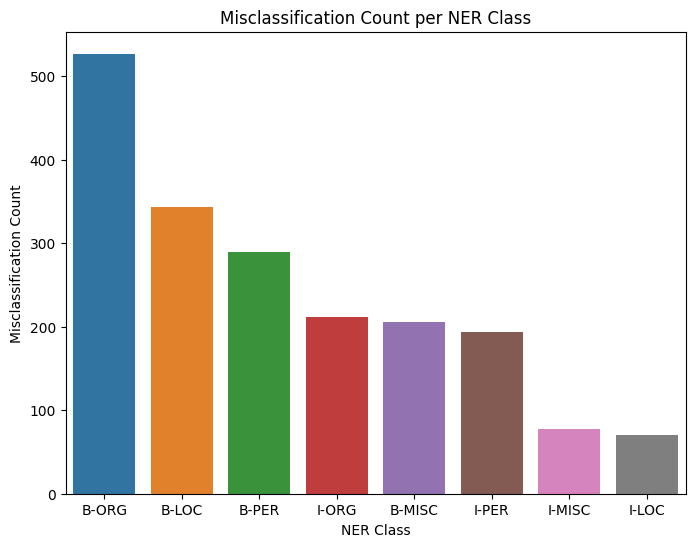

In [30]:
# Visualize misclassification distribution
plt.figure(figsize=(8,6))
sns.barplot(x='NER Class', y='Misclassification Count', data=error_counts)
plt.title('Misclassification Count per NER Class')
plt.show()